In [2]:
# Dataset: https://github.com/nishitpatel01/Fake_News_Detection/tree/master/liar_dataset
# Currently only used cross_val_score on train dataset
import pandas as pd
import nltk, re
import seaborn as sns
import numpy as np
#from wordcloud 
import WordCloud
import matplotlib.pyplot as plt
from collections import Counter
from nltk.corpus import stopwords
from nltk.stem.porter import PorterStemmer
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import cross_val_score, train_test_split
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier

ModuleNotFoundError: No module named 'WordCloud'

In [2]:
# Labels
names = ['ID', 'label', 'statement', 'subject(s)', 'speaker',
         "speaker's job title", 'state info', 'party affiliation',
         'barely true counts', 'false counts', 'half true counts', 
         'mostly true counts', 'pants of fire counts', 'context']
df = pd.read_csv('train.tsv', sep='\t', encoding='utf-8', 
                  names=names)

In [3]:
# Glimpse of the dataset
df.head()

,ID,label,statement,subject(s),speaker,speaker's job title,state info,party affiliation,barely true counts,false counts,half true counts,mostly true counts,pants of fire counts,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,Florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on CNN


Distribution of different labels: 
half-true      2114
false          1995
mostly-true    1962
true           1676
barely-true    1654
pants-fire      839
Name: label, dtype: int64


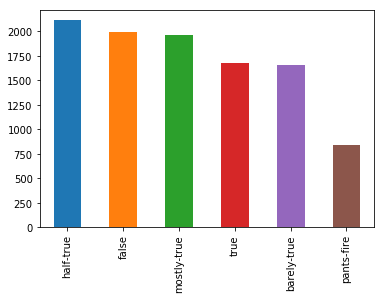

In [4]:
# Get the distribution of the different labels
print 'Distribution of different labels: \n', df['label'].value_counts()
df['label'].value_counts().plot(kind='bar')

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 14 columns):
ID                      10240 non-null object
label                   10240 non-null object
statement               10240 non-null object
subject(s)              10238 non-null object
speaker                 10238 non-null object
speaker's job title     7343 non-null object
state info              8032 non-null object
party affiliation       10238 non-null object
barely true counts      10238 non-null float64
false counts            10238 non-null float64
half true counts        10238 non-null float64
mostly true counts      10238 non-null float64
pants of fire counts    10238 non-null float64
context                 10138 non-null object
dtypes: float64(5), object(9)
memory usage: 1.1+ MB


In [6]:
# To make things simpler, converted
# barely-true, false, pants-fire -> unreliable
# true, most-true, half-true -> reliable
df_new = df[['statement', 'label']]
df_new.loc[df_new['label'].isin(['barely-true', 'false', 'pants-fire']), ['label']] = 'unreliable'
df_new.loc[df_new['label'].isin(['true', 'mostly-true', 'half-true']), ['label']] = 'reliable'

/usr/local/lib/python2.7/site-packages/pandas/core/indexing.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._setitem_with_indexer(indexer, value)
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """
/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


In [7]:
df_new[df_new['label'] == 'unreliable']['statement'].values[:5]

array([u'Says the Annies List political group supports third-trimester abortions on demand.',
       u'Health care reform legislation is likely to mandate free sex change surgeries.',
       u'Jim Dunnam has not lived in the district he represents for years now.',
       u'When Mitt Romney was governor of Massachusetts, we didnt just slow the rate of growth of our government, we actually cut it.',
       u'Most of the (Affordable Care Act) has already in some sense been waived or otherwise suspended.'],
      dtype=object)

In [8]:
df_new[df_new['label'] == 'reliable']['statement'].values[:5]

array([u'When did the decline of coal start? It started when natural gas took off that started to begin in (President George W.) Bushs administration.',
       u'Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."',
       u'The economic turnaround started at the end of my term.',
       u'The Chicago Bears have had more starting quarterbacks in the last 10 years than the total number of tenured (UW) faculty fired during the last two decades.',
       u"I'm the only person on this stage who has worked actively just last year passing, along with Russ Feingold, some of the toughest ethics reform since Watergate."],
      dtype=object)

In [9]:
# Distribution of the labels in the new dataset
df_new['label'].value_counts()

reliable      5752
unreliable    4488
Name: label, dtype: int64

In [10]:
# No Nan, null values, not going over that preprocessing step
df_new.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10240 entries, 0 to 10239
Data columns (total 2 columns):
statement    10240 non-null object
label        10240 non-null object
dtypes: object(2)
memory usage: 160.1+ KB


### Is there a difference between real and fake articles based on word count?

/usr/local/lib/python2.7/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


Stats regarding the word count in title: 
count    10240.000000
mean        20.175293
std         10.878936
min          2.000000
25%         14.000000
50%         19.000000
75%         25.000000
max        546.000000
Name: statement, dtype: float64


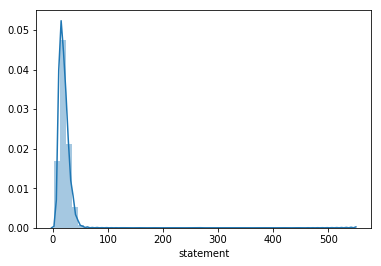

In [11]:
# Get a sense of the word distribution count in the statement of the article
# 75% of the articles have a statement word count distribution of <= 25 
statement_counts = df_new['statement'].apply(lambda sent: nltk.word_tokenize(sent)).str.len()
sns.distplot(statement_counts)
print 'Stats regarding the word count in title: \n', statement_counts.describe()

Stats regarding the word count in title of fake articles: 
count    4488.000000
mean       19.540553
std         9.934336
min         2.000000
25%        13.000000
50%        18.000000
75%        24.000000
max       356.000000
Name: statement, dtype: float64


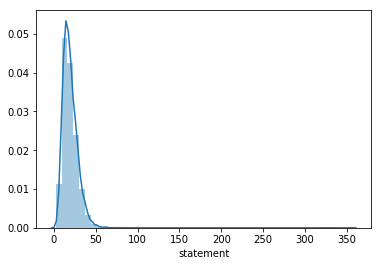

In [12]:
# Get a sense of word count distribution of statements among fake articles
statement_counts = df_new[df_new['label'] == 'unreliable']['statement'].apply(lambda sent: nltk.word_tokenize(sent)).str.len()
sns.distplot(statement_counts)
print 'Stats regarding the word count in title of fake articles: \n', statement_counts.describe()

Stats regarding the word count in title of fake articles: 
count    5752.000000
mean       20.670549
std        11.539117
min         2.000000
25%        14.000000
50%        19.000000
75%        25.000000
max       546.000000
Name: statement, dtype: float64


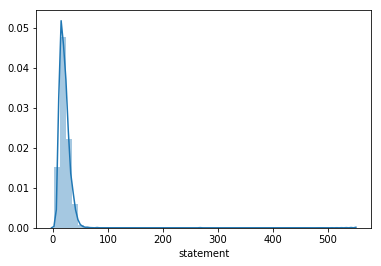

In [13]:
# Get a sense of word count distribution of statements among real articles
statement_counts = df_new[df_new['label'] == 'reliable']['statement'].apply(lambda sent: nltk.word_tokenize(sent)).str.len()
sns.distplot(statement_counts)
print 'Stats regarding the word count in title of fake articles: \n', statement_counts.describe()

In [14]:
# Normalized vocab count statements
COUNT = 10
statements = ' '.join(df_new['statement'].apply(lambda sent: sent.lower()).values)
counter = Counter(nltk.word_tokenize(statements))
total = sum(counter.values(), 0.0)
for x in counter:
    counter[x] /= total
print '{0} most common used words in titles: \n{1}'.format(COUNT, counter.most_common(COUNT))
print 'Vocab count: ', len(counter.keys())

10 most common used words in titles: 
[(u'.', 0.054083403628183875), (u'the', 0.0474369043117407), (u',', 0.025907288364020672), (u'in', 0.02481165827976381), (u'of', 0.023299107013002123), (u'to', 0.021713836935338432), (u'a', 0.01778217322590341), (u'and', 0.013690528132483977), (u'says', 0.011489572122516653), (u'for', 0.010263048178636183)]
Vocab count:  13682


In [15]:
# Normalized vocab count statements - fake articles
COUNT = 10
statements = ' '.join(df_new[df_new['label'] == 'unreliable']['statement'].apply(lambda sent: sent.lower()).values)
counter = Counter(nltk.word_tokenize(statements))
total = sum(counter.values(), 0.0)
for x in counter:
    counter[x] /= total
print '{0} most common used words in titles: \n{1}'.format(COUNT, counter.most_common(COUNT))
print 'Vocab count: ', len(counter.keys())

10 most common used words in titles: 
[(u'.', 0.055010675587728215), (u'the', 0.04540835550278022), (u',', 0.02507335898519119), (u'to', 0.02446821871824441), (u'in', 0.022413025358802508), (u'of', 0.02088304808010687), (u'a', 0.01848532249409132), (u'says', 0.013164655241313954), (u'and', 0.013061895573341859), (u'for', 0.010664169987326307)]
Vocab count:  9213


In [16]:
# Normalized vocab count statements - real articles
COUNT = 10
statements = ' '.join(df_new[df_new['label'] == 'reliable']['statement'].apply(lambda sent: sent.lower()).values)
counter = Counter(nltk.word_tokenize(statements))
total = sum(counter.values(), 0.0)
for x in counter:
    counter[x] /= total
print '{0} most common used words in titles: \n{1}'.format(COUNT, counter.most_common(COUNT))
print 'Vocab count: ', len(counter.keys())

10 most common used words in titles: 
[(u'.', 0.0533991625312787), (u'the', 0.04893378604948985), (u'in', 0.026581627924610964), (u',', 0.026522651254096773), (u'of', 0.025081935445821504), (u'to', 0.019681357474450465), (u'a', 0.01726331398336858), (u'and', 0.014154400923406155), (u'says', 0.010253515430824579), (u'for', 0.009967057316898502)]
Vocab count:  10051


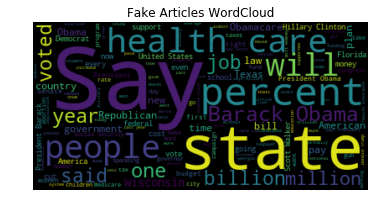

In [17]:
# Get a sense of the words used in fake articles
# Seems like the distribution of words is same for unreliable and reliable articles.
unreliable_statements = '. '.join(df_new[df_new['label'] == 'unreliable']['statement'].values)
wordcloud = WordCloud().generate(unreliable_statements)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Fake Articles WordCloud')

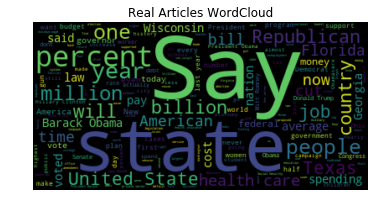

In [18]:
# Get a sense of the words used in fake articles
reliable_statements = '. '.join(df_new[df_new['label'] == 'reliable']['statement'].values)
wordcloud = WordCloud().generate(reliable_statements)
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
_ = plt.title('Real Articles WordCloud')

In [19]:
# Done some preprocessing, remove punctuation, stopwords; stemming
df_new['statement'] = df_new['statement'].apply(lambda sent: re.sub(r'[^\w\s]','', sent.lower()))
print df_new['statement'].head()
X, y = df_new[['statement']]['statement'].apply(lambda sent: sent.lower()).values, df_new[['label']].values
print X[:10], y[:10]
X_stem = []
stemmer = SnowballStemmer("english")
for sent in X:
    X_stem.append(' '.join([stemmer.stem(word) for word in nltk.word_tokenize(sent) if word not in stopwords.words('english')]))
X_stem[:10]

/usr/local/lib/python2.7/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


0    says the annies list political group supports ...
1    when did the decline of coal start it started ...
2    hillary clinton agrees with john mccain by vot...
3    health care reform legislation is likely to ma...
4    the economic turnaround started at the end of ...
Name: statement, dtype: object
[u'says the annies list political group supports thirdtrimester abortions on demand'
 u'when did the decline of coal start it started when natural gas took off that started to begin in president george w bushs administration'
 u'hillary clinton agrees with john mccain by voting to give george bush the benefit of the doubt on iran'
 u'health care reform legislation is likely to mandate free sex change surgeries'
 u'the economic turnaround started at the end of my term'
 u'the chicago bears have had more starting quarterbacks in the last 10 years than the total number of tenured uw faculty fired during the last two decades'
 u'jim dunnam has not lived in the district he represents for ye

[u'say anni list polit group support thirdtrimest abort demand',
 u'declin coal start start natur gas took start begin presid georg w bush administr',
 u'hillari clinton agre john mccain vote give georg bush benefit doubt iran',
 u'health care reform legisl like mandat free sex chang surgeri',
 u'econom turnaround start end term',
 u'chicago bear start quarterback last 10 year total number tenur uw faculti fire last two decad',
 u'jim dunnam live district repres year',
 u'im person stage work activ last year pass along russ feingold toughest ethic reform sinc waterg',
 u'howev took 195 million oregon lotteri fund port newport eventu land new noaa marin oper centerpacif',
 u'say gop primari oppon glenn grothman joe leibham cast compromis vote cost 788 million higher electr cost']

In [20]:
tfidf = TfidfVectorizer(strip_accents='unicode',
                        ngram_range=(1, 2),
                        # stop_words=stopwords.words('english')
                        )
X_t = tfidf.fit_transform(X_stem)

In [21]:
clf = LogisticRegression()
print cross_val_score(clf, X_t, y.reshape(-1,), cv=5)

/usr/local/lib/python2.7/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


[0.61542216 0.6159102  0.60400391 0.62432829 0.61211529]


In [22]:
# Taking too much time ...
clf = AdaBoostClassifier(SVC(probability=True, kernel='linear'))
print cross_val_score(clf, X_t, y.reshape(-1,), cv=3, verbose=5, n_jobs=-1)

[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.


[0.56151142 0.56226194 0.56255494]


[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 107.5min remaining:    0.0s
[Parallel(n_jobs=-1)]: Done   3 out of   3 | elapsed: 107.5min finished


In [23]:
clf = LinearSVC()
print cross_val_score(clf, X_t, y.reshape(-1,), cv=5)

[0.60614934 0.60663738 0.59326172 0.60478749 0.60967269]


In [24]:
clf = MultinomialNB()
print cross_val_score(clf, X_t, y.reshape(-1,), cv=5)

[0.59736457 0.61346999 0.59667969 0.61651197 0.60869565]


In [25]:
clf = RandomForestClassifier()
print cross_val_score(clf, X_t, y.reshape(-1,), cv=5)

/usr/local/lib/python2.7/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


[0.58369937 0.58174719 0.56787109 0.58817782 0.5852467 ]
